In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
from fgbuster import CMB, Dust, Synchrotron, MixingMatrix
from fgbuster.observation_helpers import standardize_instrument, get_observation
import matplotlib.pyplot as plt
import emcee
import healpy as hp
from getdist import MCSamples, plots

In [2]:

#INSTRUMENT
instr = np.load('/Users/alicepirotta/Desktop/APC/MCMC/instrument_LB_IMOv1.npy', allow_pickle=True).item()
instr_ = {}
instr_['frequency'] = np.array([instr[f]['freq'] for f in instr.keys()])
instr_['depth_p'] = np.array([instr[f]['P_sens'] for f in instr.keys()])
instr_['fwhm'] = np.array([instr[f]['beam'] for f in instr.keys()])
instr_['depth_i'] = instr_['depth_p']/np.sqrt(2)
instrument = standardize_instrument(instr_)
print(instr_['frequency'])




#SKY MAP
nside = 4
freq_maps = get_observation(instrument, 'd0s0', noise=False, nside=nside)

n_freqs = freq_maps.shape[0]
n_stokes = freq_maps.shape[1]
n_pix = freq_maps.shape[2]


components= [CMB(),Dust(50.),Synchrotron(50.)]
A = MixingMatrix(*components)
A_ev = A.evaluator(instrument.frequency)


#NOISE
#invN=np.linalg.inv(np.eye(len(instrument.frequency)))
N = np.diag((instrument.depth_p / hp.nside2resol(nside, arcmin=True))**2)
invN = np.linalg.inv(N)


#INITIAL PARAMETERS
x_true =np.array([1.54,20,-3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])



def lnprior(y):
    Bd, Td, Bs, a, b, c, d, e, f, g, i, l, m , n, o, p, q, r, s, t, u, v, w, z = y
    if ((Bd < 0.) or (Bd > 2.) or
        (Td < 10.) or (Td > 30.) or
        (Bs < -4.) or (Bs > -2.) or  
        (a < 0.) or
        (b < 0.) or
        (c < 0.) or
        (d < 0.) or
        (e < 0.) or
        (f < 0.) or
        (g < 0.) or
        (i < 0.) or
        (l < 0.) or
        (m < 0.) or
        (n < 0.) or
        (o < 0.) or
        (p < 0.) or
        (q < 0.) or
        (r < 0.) or
        (s < 0.) or
        (t < 0.) or
        (u < 0.) or
        (v < 0.) or
        (w < 0.) or
        (z < 0.)):
        return -np.inf
    else:
        return 0.0
    

dati = np.einsum('abc,cbx-> ax',freq_maps,freq_maps.T)
   
def aver_likelihood(y):
    Bd, T, Bs, a, b, c, d, e, f, g, i, l, m, n, o, p, q, r, s, t, u, v, w, z = y
    h= 1
    G = np.diag([a, b, c, d, e, f, g, h, i, l, m, n, o, p, q, r, s, t, u, v, w, z ])
    A =G.dot(A_ev(np.array([Bd,T,Bs]))) 
    P=invN-invN.dot(A).dot(np.linalg.inv(A.T.dot(invN.dot(A))).dot(A.T).dot(invN))
    NP = invN-P
    dN = dati+N
    NP_dN = np.einsum('ab,bx->ax', NP,dN)
    logL = -np.trace(NP_dN)/2
    if logL != logL:
        return 0.0
    return logL


def lnprob(x):
    lp = lnprior(x)
    return lp + aver_likelihood(x)

[ 40.  50.  60.  68.  68.  78.  78.  89.  89. 100. 119. 140. 100. 119.
 140. 166. 195. 195. 235. 280. 337. 402.]


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
aver_likelihood(x_true)

-15797931768770.836

In [4]:
#params for MCMC
nsteps= 800000
ndim,nwalkers=24,50
np.random.seed(10)
x_init = np.random.uniform(low=x_true * (1 - 1 / 40), high= x_true * (1 + 1 / 40), size=(nwalkers, ndim))

100%|██████████| 500000/500000 [49:24<00:00, 168.68it/s] 


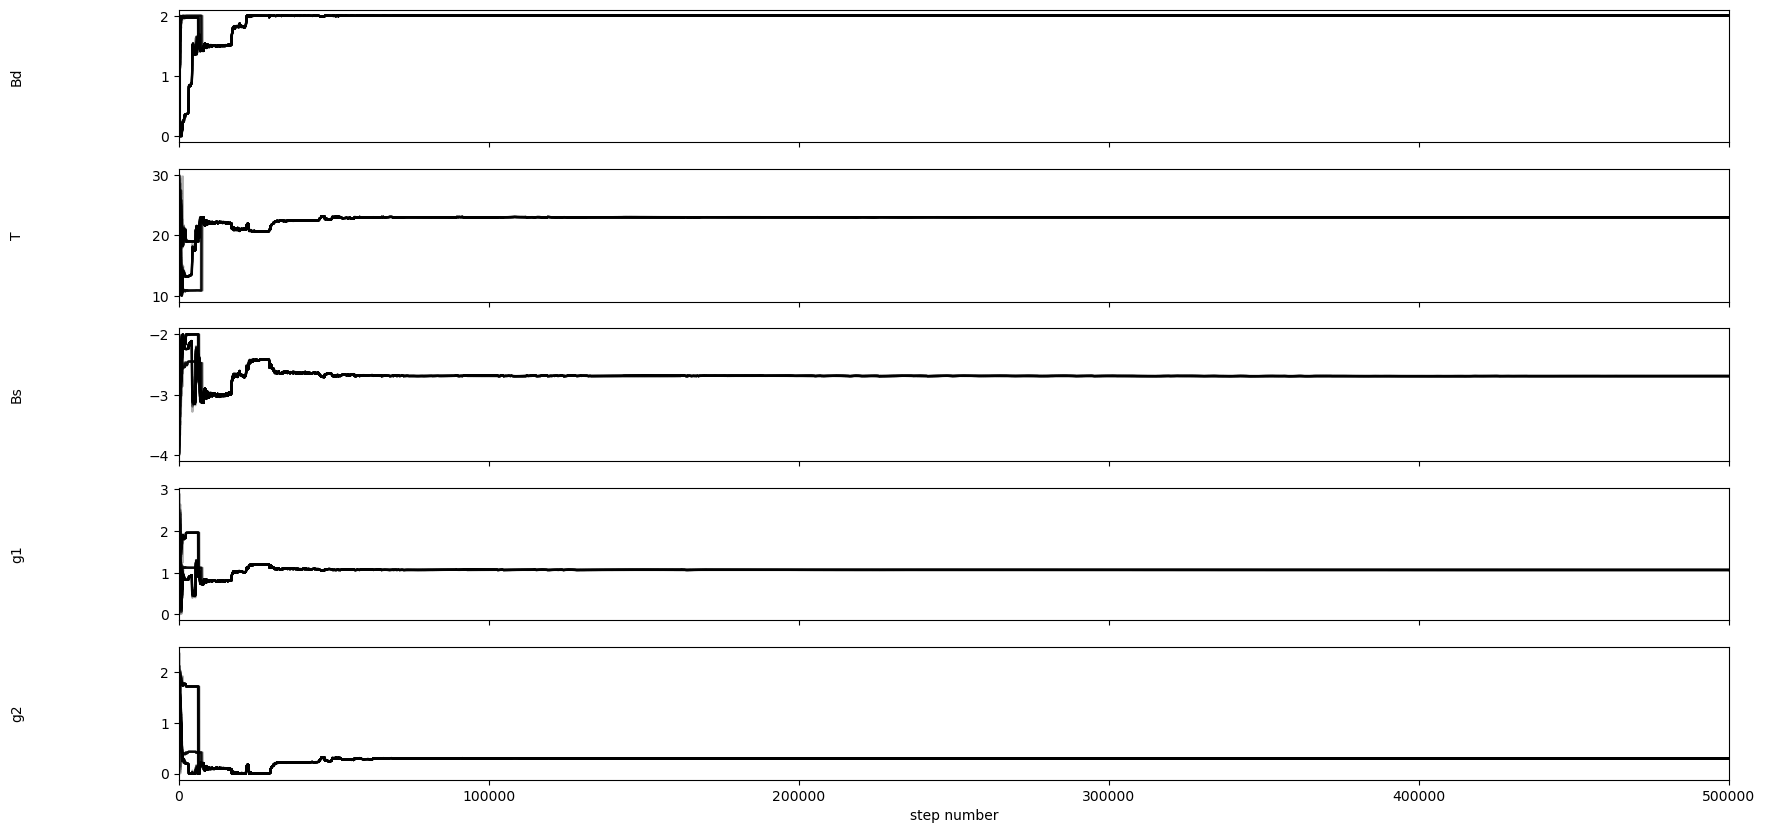

In [5]:
#SAMPLE
 
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
sampler.run_mcmc(x_init,nsteps, progress=True)
samples = sampler.get_chain(flat=False)

filename= str(nsteps)+'_aver'
np.save(filename,samples)

nparam_plot=5
fig, axes = plt.subplots(nparam_plot, figsize=(20,10), sharex=True)
labels=["Bd", "T", "Bs", "g1", "g2", "g3", "g4", "g5", "g6", "g7", "g9", "g10", "g11", "g12", "g13", "g14", "g15", "g16", "g17", "g18", "g19", "g20", "g21", "g22" ]
for i in range(nparam_plot):
    ax = axes[i]
    ax.plot(samples[:,:, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


In [16]:
# #triangle_plot raw sample(no thin, no discard)
# samples_flat = sampler.get_chain(flat=True)
# s1 = MCSamples(samples=samples_flat, names=["Bd", "T", "Bs",  "g1", "g2", "g3", "g4", "g5", "g6", "g7", "g9", "g10", "g11", "g12", "g13", "g14", "g15", "g16", "g17", "g18", "g19", "g20", "g21", "g22" ], labels=["Bd", "T", "Bs",  "g1", "g2", "g3", "g4", "g5", "g6", "g7", "g9", "g10", "g11", "g12", "g13", "g14", "g15", "g16", "g17", "g18", "g19", "g20", "g21", "g22" ], label='21g')
# g = plots.get_subplot_plotter()
# g.triangle_plot([s1], filled=True, title_limit= True)

In [6]:
#AUTOCORRELATION TIME
tau = sampler.get_autocorr_time(quiet=True)


The chain is shorter than 50 times the integrated autocorrelation time for 15 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10000;
tau: [13600.82656451 20549.99321301  2442.94247414  5177.79266449
 12561.31743594 18566.0206917  19432.7064495  30511.79363053
 19040.83458969 20661.04275632 26423.20009597 28614.21482393
 25672.22704724 22219.40737136 23615.14360766 16833.07592427
 11840.01986673  3391.51062137  2031.07578305  4956.76392934
  1679.93049671  2429.52134942  2281.17678864  1411.1241339 ]


In [32]:
#DISCARD vs BURNIN
discard= 450000
burnin=discard
samples_flat_discard = sampler.get_chain(discard=discard, thin=int(max(tau)), flat=True) #[nstep*nwalkers,nparams]
samples_burnin= samples[burnin:, :, :] #[nstep,nwalkers,nparams]

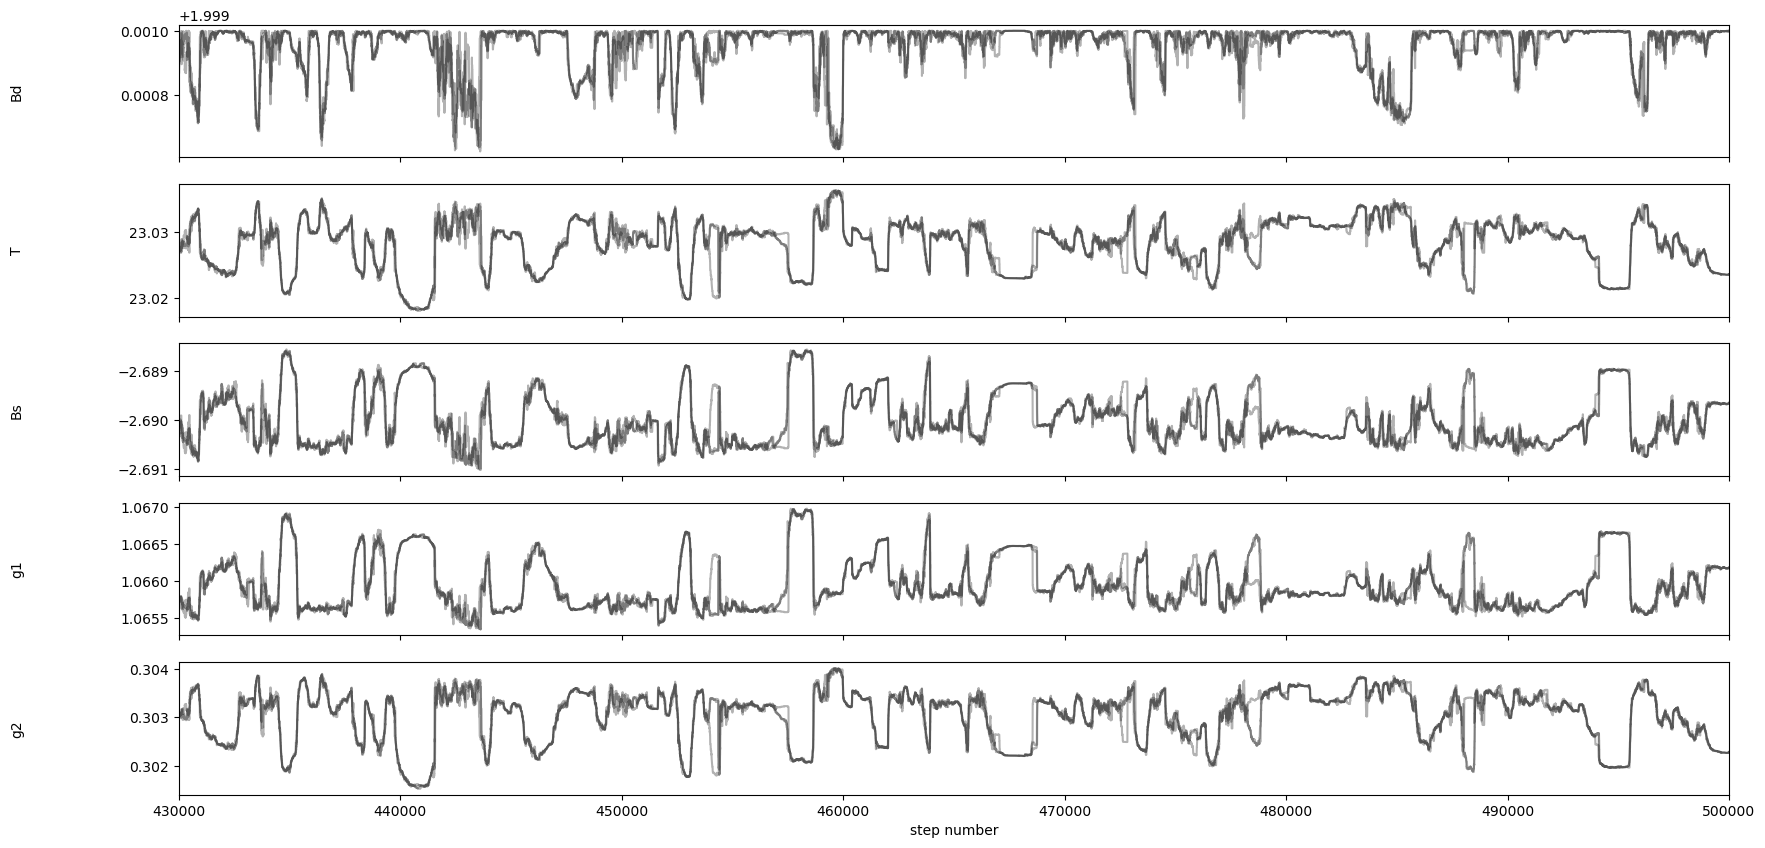

In [33]:
fig, axes = plt.subplots(nparam_plot, figsize=(20,10), sharex=True)
x_steps=np.arange(burnin,nsteps)
labels=["Bd", "T", "Bs", "g1", "g2", "g3", "g4", "g5", "g6", "g7", "g9", "g10", "g11", "g12", "g13", "g14", "g15", "g16", "g17", "g18", "g19", "g20", "g21", "g22" ]
for i in range(nparam_plot):
    ax = axes[i]
    for j in range(3):   #nwalkers):
        ax.plot( x_steps,samples_burnin[:,j,i] ,"k", alpha=0.3)
        ax.set_xlim(burnin, samples_burnin.shape[0]+burnin)
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");


Removed no burn in


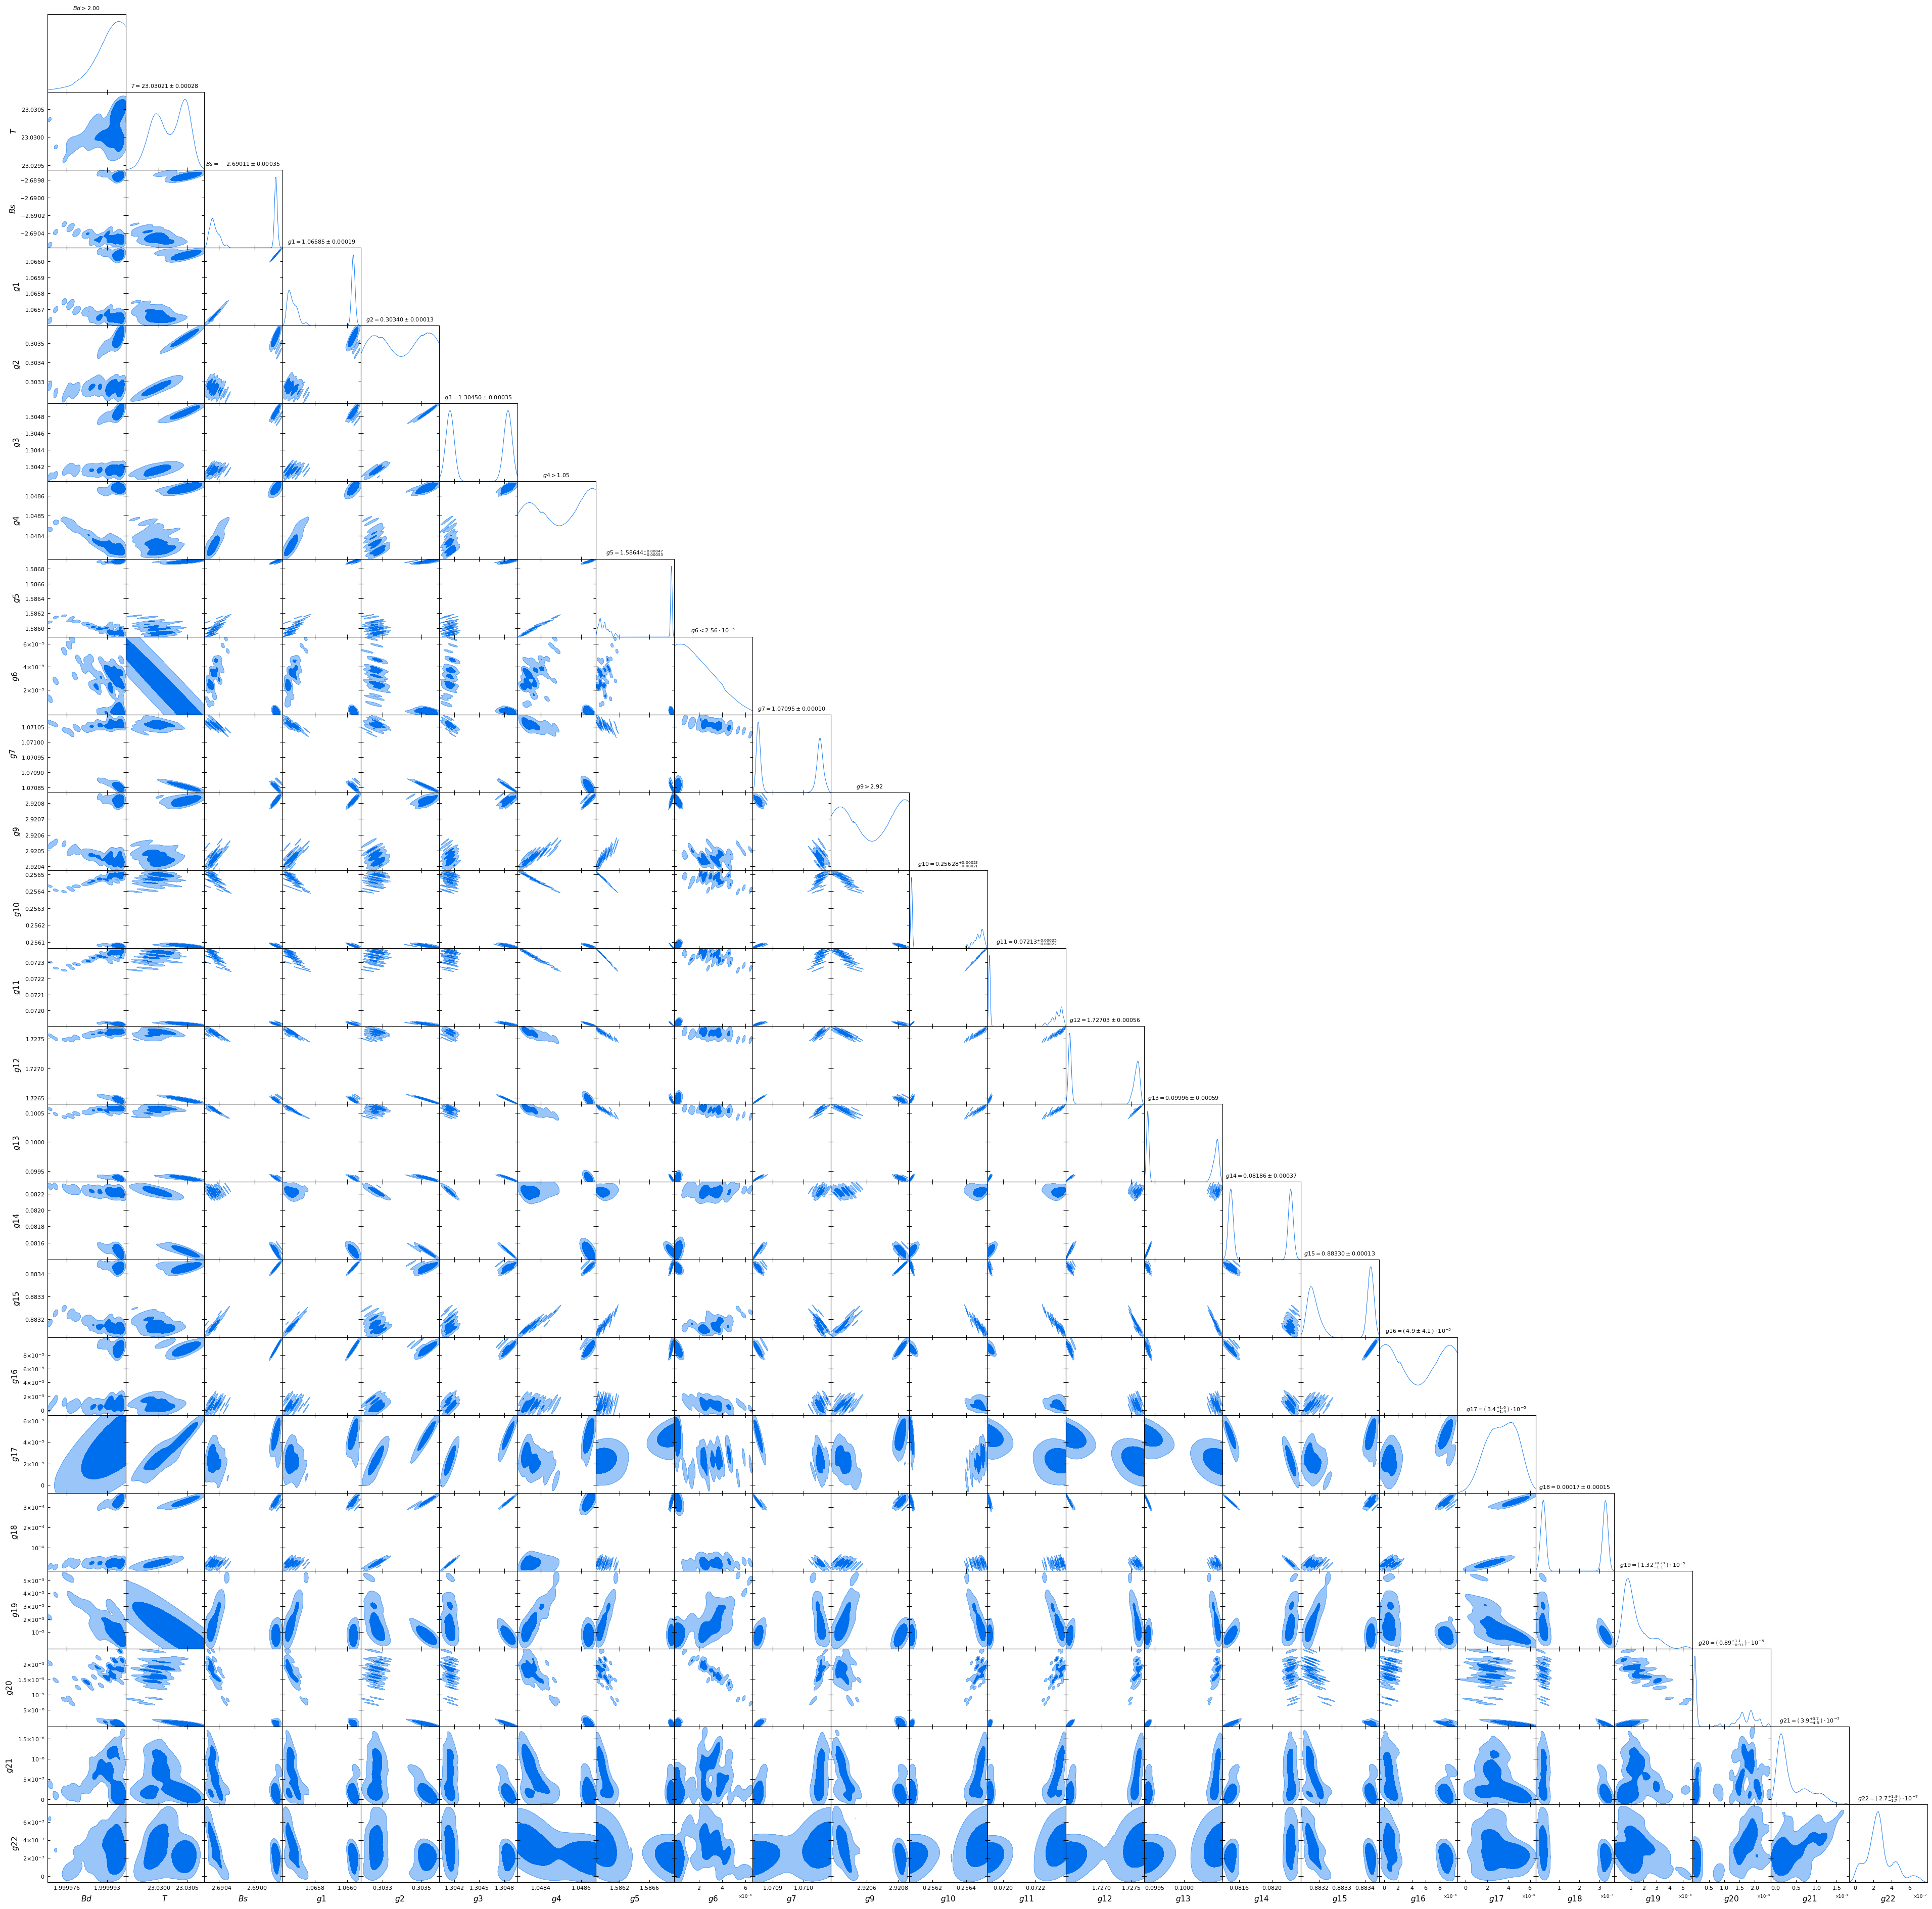

In [34]:

s1 = MCSamples(samples=samples_flat_discard, names=["Bd", "T", "Bs",  "g1", "g2", "g3", "g4", "g5", "g6", "g7", "g9", "g10", "g11", "g12", "g13", "g14", "g15", "g16", "g17", "g18", "g19", "g20", "g21", "g22" ], labels=["Bd", "T", "Bs",  "g1", "g2", "g3", "g4", "g5", "g6", "g7", "g9", "g10", "g11", "g12", "g13", "g14", "g15", "g16", "g17", "g18", "g19", "g20", "g21", "g22" ], label='21g')
g = plots.get_subplot_plotter()
g.triangle_plot([s1], filled=True, title_limit= True)